# RNN 개념이해

* 서울의 주간평균기온 데이터를 이용하여 RNN 모델을 구현해 봅시다.

## 1.환경 준비

### (1) 라이브러리 로딩

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Flatten
from keras.backend import clear_session
from keras.optimizers import Adam

### (2) 필요한 함수 생성

* 학습곡선 함수

In [3]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

* 데이터 2 --> 3차원 변환

In [4]:
# 시계열 데이터 전처리 2차원 --> 3차원으로 변환
def temporalize(x, y, timesteps):
    nfeature = x.shape[1]
    output_x = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        t = []
        for j in range(timesteps):
            t.append(x[[(i + j)], :])
        output_x.append(t)
        output_y.append(y[i + timesteps - 1])
    return np.array(output_x).reshape(-1,timesteps, nfeature), np.array(output_y)

### (3) Data Loading
서울시의 주간별 평균기온 데이터 (2010-2014 5년치 데이터)

In [5]:
data = pd.read_csv('https://raw.githubusercontent.com/DA4BAM/dataset/master/temperature.csv')
data.head(10)

,year,week,AvgTemp
0,2010,1,-3.000000
1,2010,2,-7.500000
2,2010,3,-7.900000
3,2010,4,-2.357143
4,2010,5,-3.342857
5,2010,6,-1.800000
6,2010,7,-0.314286
7,2010,8,-2.142857
8,2010,9,4.400000
9,2010,10,7.057143


## 2.데이터 이해

온도의 흐름(trend)을 살펴봅시다.

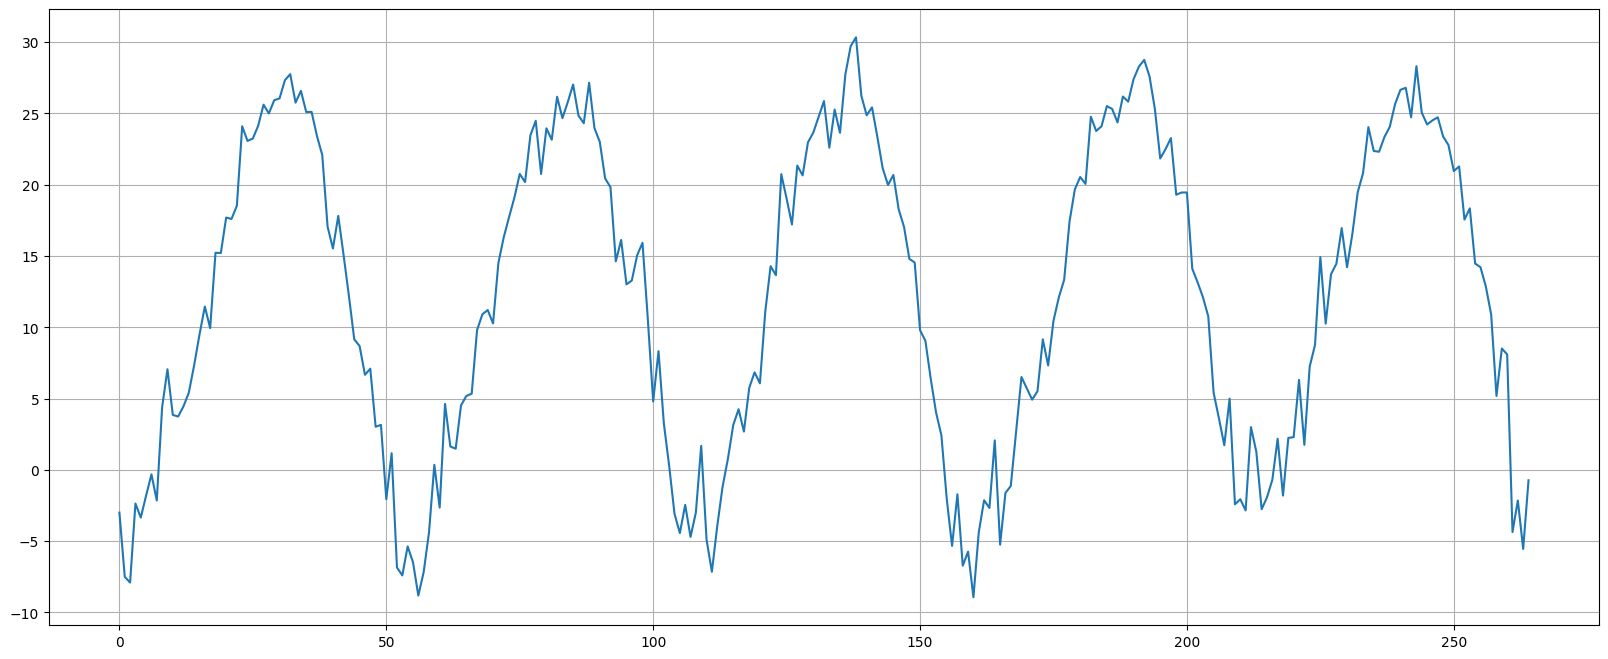

In [6]:
plt.figure(figsize = (20,8))
plt.plot(data.AvgTemp)
plt.grid()
plt.show()

##3.데이터 준비

### (1) y 만들기

In [7]:
data['y'] = data['AvgTemp'].shift(-1)
data.dropna(axis = 0, inplace = True)
data.head()

,year,week,AvgTemp,y
0,2010,1,-3.000000,-7.500000
1,2010,2,-7.500000,-7.900000
2,2010,3,-7.900000,-2.357143
3,2010,4,-2.357143,-3.342857
4,2010,5,-3.342857,-1.800000


### (2) x, y 분리

In [8]:
x = data.loc[:, ['AvgTemp']]
y = data.loc[:,'y']

### (3) 스케일링
- 데이터가 많으면 통으로 스케일링해도 괜찮음.
- 데이터가 적으면 train set과 val set의 범위가 달라질 수 있는데, 데이터가 많으면 거의 차이가 없음
- 근데 왜 굳이? => sklearn이 제공하는 scaler는 2차원 구조만 스케일링을 지원하므로, 2차원일 때 스케일링하고, 3차원으로 바꿨을 뿐임

In [9]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

In [10]:
x.shape, y.shape

((264, 1), (264,))

### (4) 3차원 구조 만들기

In [11]:
x2, y2 = temporalize(x, y, 4) # 4 = time step (주)
x2.shape, y2.shape # 4행 1열 데이터가 261건 있다 (한 행에 대해 4주간의 데이터가 있음)

((261, 4, 1), (261,))

In [12]:
x2[:2]

array([[[0.15106693],
        [0.0364937 ],
        [0.02630941],
        [0.16743453]],

       [[0.0364937 ],
        [0.02630941],
        [0.16743453],
        [0.14233754]]])

### (5) 데이터 분할

* shuffle = False : 섞지 마라.(랜덤 분할 하지 마라)
* test_size= 53 : (1년이 53주)
    * 소수 : 비율
    * 자연수 : 개수

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 53, shuffle = False)

In [14]:
x_train.shape, y_train.shape

((208, 4, 1), (208,))

In [15]:
x_val.shape, y_val.shape

((53, 4, 1), (53,))

## 4.RNN : 무작정 모델링

### (1) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [15]:
x_train.shape

(208, 4, 1)

In [16]:
timesteps = x_train.shape[1]
nfeatures = x_train.shape[2]
print(timesteps, nfeatures)

4 1


### (2) 모델 구조 설계
* 다음 구조를 그대로 설계해 봅시다.
    * SimpleRNN(8, input_shape = (timesteps, nfeatures))
    * Dense(1)

In [17]:
clear_session()

model = Sequential([
    SimpleRNN(8, input_shape = (timesteps, nfeatures)), # hidden layer
    # (LSTM, RNN 레이어는 default로 activation 함수가 지정되어 있음 (tanh) -> 따로 지정해줄 필요 x)
    Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89 (356.00 Byte)
Trainable params: 89 (356.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### (3) 컴파일 및 학습
* 다음 조건으로 학습해 봅시다.
    * epochs = 100
    * learning_rate = 0.01

In [18]:
model.compile(optimizer = Adam(learning_rate=0.01), loss = 'mse')
history = model.fit(x_train, y_train, epochs=100, validation_split=.2, verbose=0).history

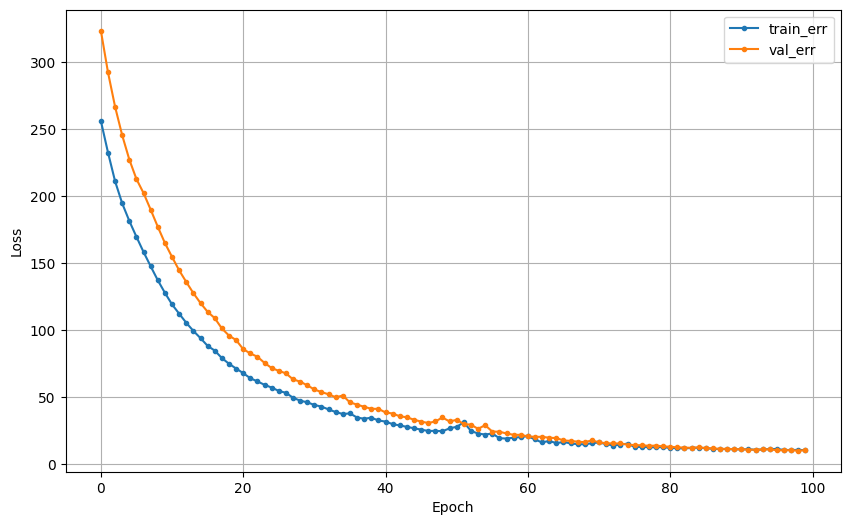

In [19]:
# 학습 곡선을 그려봅시다.
dl_history_plot(history)

### (4) 예측 및 평가

In [20]:
# 예측
pred = model.predict(x_val)

2/2 [==============================] - 0s 6ms/step


In [21]:
# 평가
print('mse: ', mean_squared_error(y_val, pred, squared=False))
print('mae: ', mean_absolute_error(y_val, pred))

mse:  4.065042274676264
mae:  3.2000736198853352


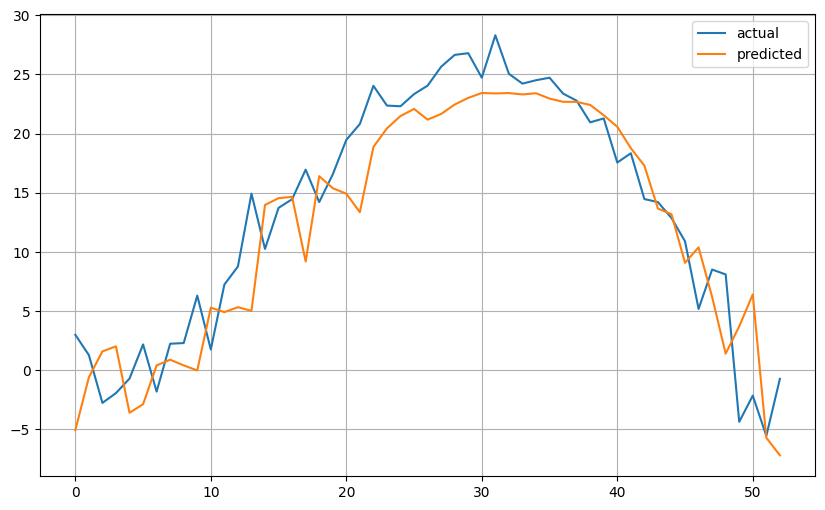

In [22]:
plt.figure(figsize = (10,6))
plt.plot(y_val, label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.grid()
plt.show()

## 5.RNN 모델링②

### (1) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [23]:
x.shape

(264, 1)

### (2) 모델 구조 설계
* 이제 RNN 레이어를 추가해 봅시다.
    * SimpleRNN(8, input_shape = (timestep, nfeatures), return_sequences = True)
    * SimpleRNN(8)
    * Dense(1)

In [25]:
clear_session()

model = Sequential([
    SimpleRNN(8, input_shape = (timesteps, nfeatures), return_sequences=True),
    SimpleRNN(8, return_sequences=False),
    Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 4, 8)              80        
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 136       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 225 (900.00 Byte)
Trainable params: 225 (900.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### (3) 컴파일 및 학습
* 다음 조건으로 학습해 봅시다.
    * epochs = 200
    * learning_rate = 0.01

In [26]:
model.compile(optimizer = Adam(learning_rate=0.01), loss = 'mse')
history = model.fit(x_train, y_train, epochs=200, validation_split=.2, verbose=0).history

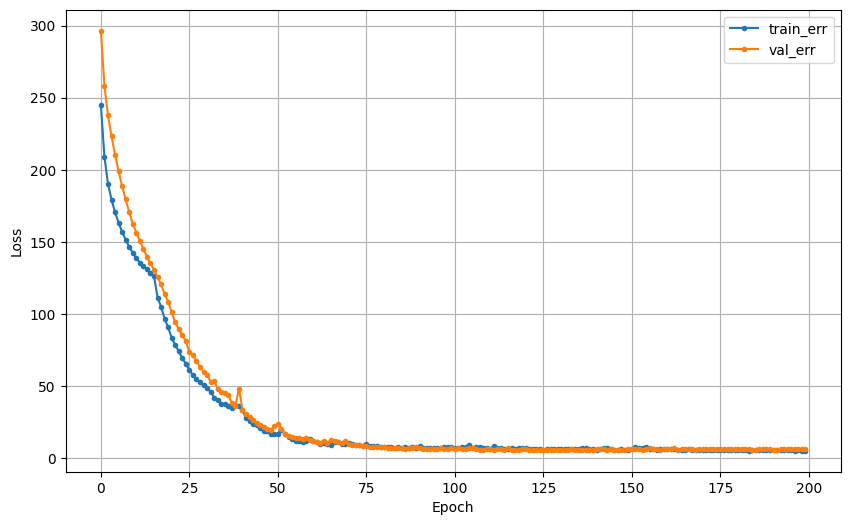

In [27]:
# 학습 곡선을 그려봅시다.
dl_history_plot(history)

### (4) 예측 및 평가

In [28]:
# 예측
pred = model.predict(x_val)

2/2 [==============================] - 0s 6ms/step


In [29]:
# 평가
print('mse: ', mean_squared_error(y_val, pred, squared=False))
print('mae: ', mean_absolute_error(y_val, pred))

mse:  2.9299340413972645
mae:  2.237533727390568


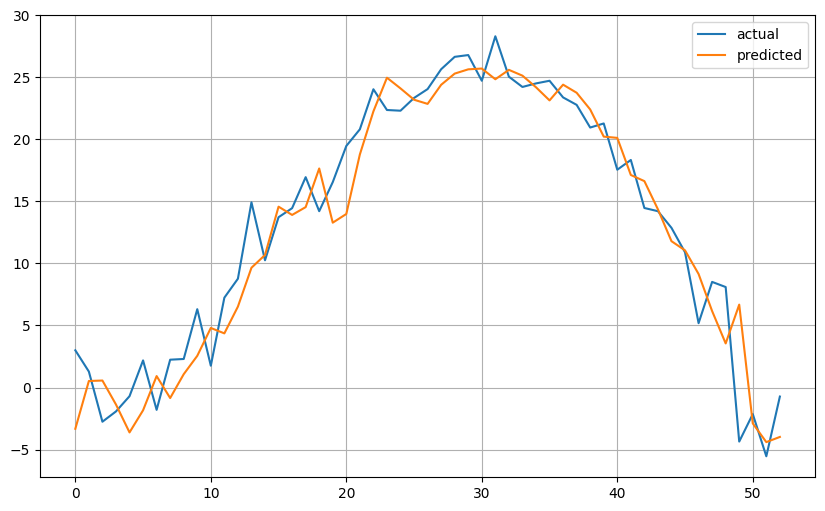

In [30]:
plt.figure(figsize = (10,6))
plt.plot(y_val, label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.grid()
plt.show()

## 6.LSTM 모델링

### (1) 데이터 준비

* timestep

In [33]:
timesteps = 14
x2, y2 = temporalize(x, y, timesteps)
x2.shape, y2.shape

((251, 14, 1), (251,))

* 데이터 분할

In [34]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 53, shuffle = False)

### (2) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [36]:
x.shape

(264, 1)

### (3) 모델 구조 설계
* 5번 모델의 SimpleRNN을 LSTM 로 이름만 바꿔봅시다.

In [53]:
clear_session()

model = Sequential([
    LSTM(8, input_shape = (timesteps, nfeatures), return_sequences=True),
    LSTM(8, return_sequences=False),
    Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 8)             320       
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 873 (3.41 KB)
Trainable params: 873 (3.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### (4) 컴파일 및 학습

In [54]:
model.compile(optimizer = Adam(learning_rate=0.01), loss = 'mse')
history = model.fit(x_train, y_train, epochs=200, validation_split=.2, verbose=0).history

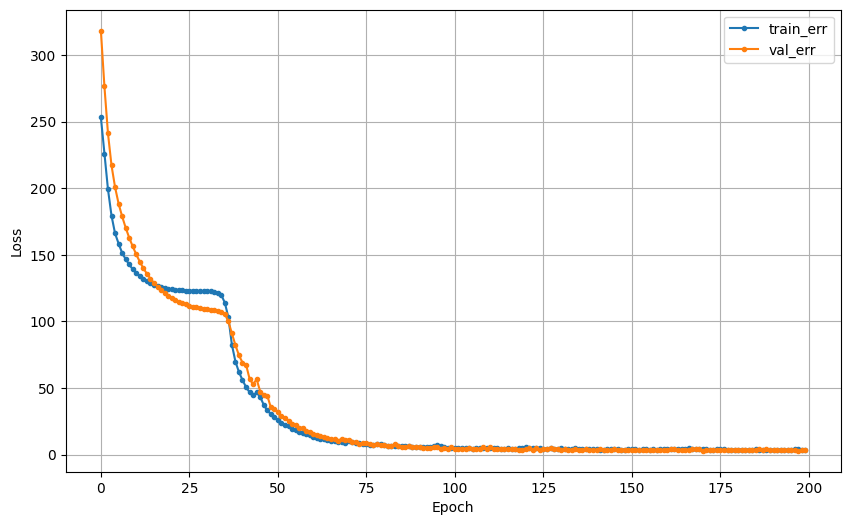

In [55]:
# 학습 곡선을 그려봅시다.
dl_history_plot(history)

### (5) 예측 및 평가

In [56]:
# 예측
pred = model.predict(x_val)

2/2 [==============================] - 1s 11ms/step


In [57]:
# 평가
print('mse: ', mean_squared_error(y_val, pred, squared=False))
print('mae: ', mean_absolute_error(y_val, pred))

mse:  2.912662633781841
mae:  2.2103047087236005


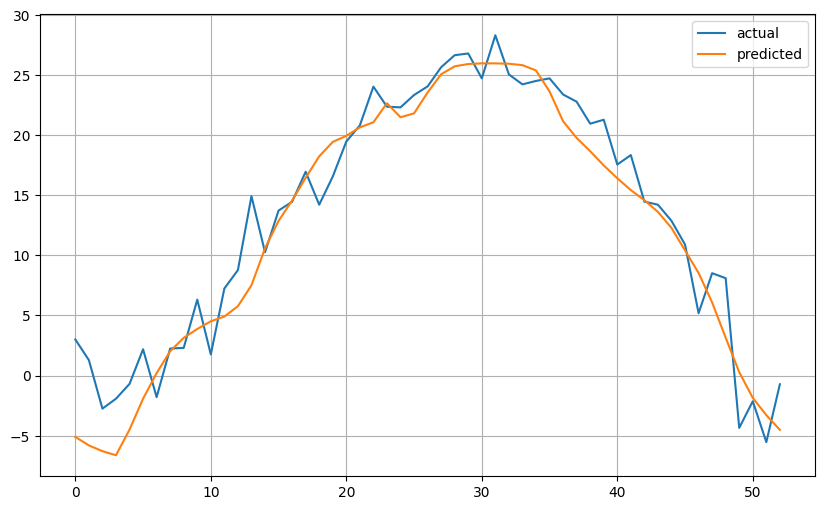

In [58]:
plt.figure(figsize = (10,6))
plt.plot(y_val, label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.grid()
plt.show()

## 7.자유롭게 모델링~!
* 다음 항목을 조정하며 모델링을 수행해 봅시다.
    * timestep
    * 레이어와 노드수
    * learning_rate, epochs


### (1) 데이터 준비

* timestep

In [16]:
timesteps = 12
x2, y2 = temporalize(x, y, timesteps)
x2.shape, y2.shape

((253, 12, 1), (253,))

* 데이터 분할

In [17]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 53, shuffle = False)

### (2) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [26]:
timesteps = x_train.shape[1]
nfeatures = x_train.shape[2]
print(timesteps, nfeatures)

12 1


### (3) 모델 구조 설계


In [40]:
clear_session()

model = Sequential([
    LSTM(8, input_shape=(timesteps, nfeatures), return_sequences= True),
    LSTM(4, return_sequences= True),
    Flatten(),
    Dense(4, activation='relu'),
    Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 8)             320       
                                                                 
 lstm_1 (LSTM)               (None, 12, 4)             208       
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 4)                 196       
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 729 (2.85 KB)
Trainable params: 729 (2.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### (4) 컴파일 및 학습

In [41]:
model.compile(Adam(learning_rate=0.01), loss='mse')
history = model.fit(x_train, y_train, epochs = 50, validation_split=.2, verbose=0).history

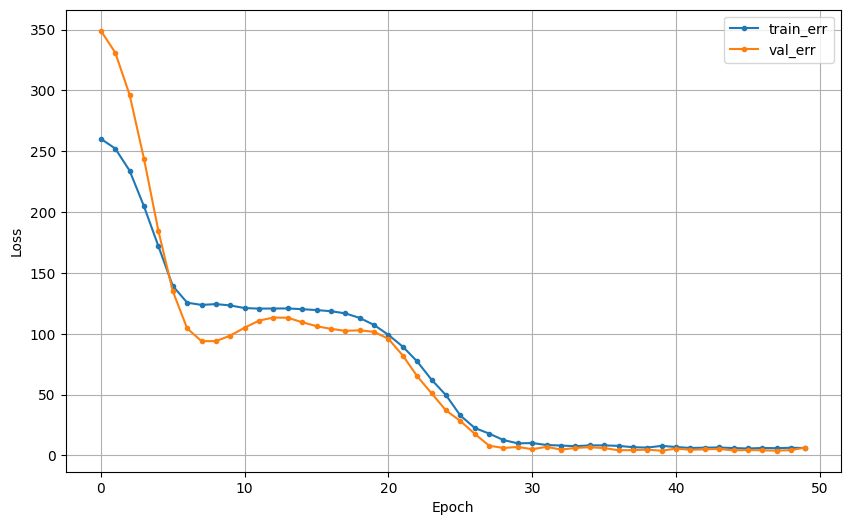

In [42]:
dl_history_plot(history)

### (5) 예측 및 평가

In [43]:
pred = model.predict(x_val)

2/2 [==============================] - 1s 9ms/step


In [44]:
print('mse: ', mean_squared_error(y_val, pred, squared=False))
print('mae: ', mean_absolute_error(y_val, pred))

mse:  2.834902716684692
mae:  2.066853521426375


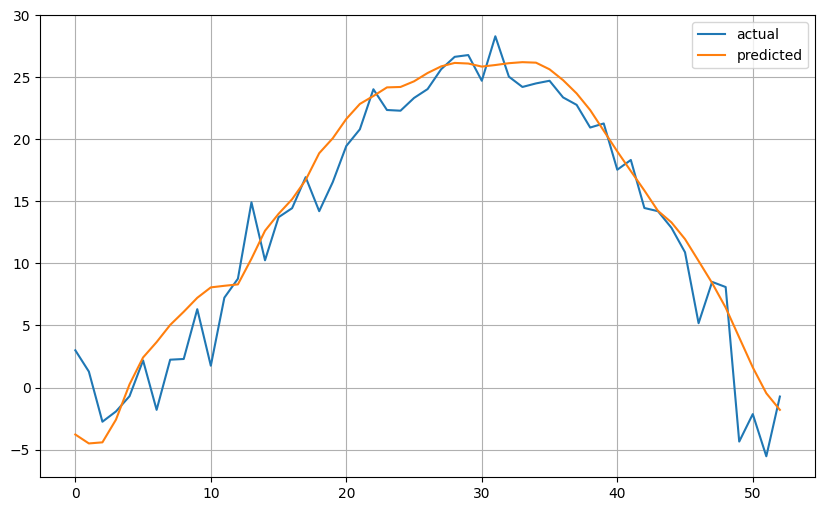

In [45]:
plt.figure(figsize = (10,6))
plt.plot(y_val, label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.grid()
plt.show()